In [10]:
import chainer
from chainer.datasets import mnist, split_dataset_random
from chainer.dataset import concat_examples
import matplotlib.pyplot as plt
from chainer import iterators, Chain
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
import numpy as np

In [11]:
train_val, test = mnist.get_mnist(withlabel=True, ndim=1)
train, valid = split_dataset_random(train_val, 50000, seed=0)

batchsize=128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

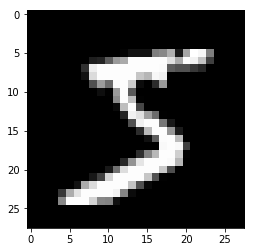

In [12]:
x, t = train_val[0]
plt.imshow(x.reshape(28, 28), cmap='gray')

In [27]:
class Model(Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        super(Model, self).__init__()
        
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)
            
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = Model()
optimizer = optimizers.SGD(lr=0.01).setup(model)

In [5]:
max_epoch=20

while train_iter.epoch < max_epoch:
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch)
    y = model(x)
    
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if train_iter.is_new_epoch:
        print('epoch:{:02d} train_loss:{:.04f}'.format(
            train_iter.epoch, float(loss.data)), end=' ')
        
        valid_losses = []
        valid_accuracies = []
        
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch)
            
            with chainer.using_config('train', False), \
                chainer.using_config('enable_backprop', False):
                    y_valid = model(x_valid)
                    
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(loss_valid.array)
            
            accuracy = F.accuracy(y_valid, t_valid)
            valid_accuracies.append(accuracy.array)
            
            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break
        
        print('val_loss:{:.04f} vali_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))
        
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch)
    
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = model(x_test)

    accuracy = F.accuracy(y_test, t_test)
    test_accuracies.append(accuracy.array)
    
    if test_iter.is_new_epoch:
        test_iter.reset()
        break
        
print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

epoch:01 train_loss:0.8899 val_loss:0.8813 vali_accuracy:0.8059
epoch:02 train_loss:0.4099 val_loss:0.5127 vali_accuracy:0.8673
epoch:03 train_loss:0.3863 val_loss:0.4187 vali_accuracy:0.8829
epoch:04 train_loss:0.3032 val_loss:0.3744 vali_accuracy:0.8934
epoch:05 train_loss:0.2676 val_loss:0.3455 vali_accuracy:0.9036
epoch:06 train_loss:0.3759 val_loss:0.3271 vali_accuracy:0.9080
epoch:07 train_loss:0.3271 val_loss:0.3108 vali_accuracy:0.9111
epoch:08 train_loss:0.2884 val_loss:0.2974 vali_accuracy:0.9156
epoch:09 train_loss:0.3930 val_loss:0.2878 vali_accuracy:0.9180
epoch:10 train_loss:0.2838 val_loss:0.2748 vali_accuracy:0.9212
epoch:11 train_loss:0.2292 val_loss:0.2670 vali_accuracy:0.9232
epoch:12 train_loss:0.2048 val_loss:0.2589 vali_accuracy:0.9256
epoch:13 train_loss:0.3419 val_loss:0.2507 vali_accuracy:0.9278
epoch:14 train_loss:0.2035 val_loss:0.2435 vali_accuracy:0.9295
epoch:15 train_loss:0.1724 val_loss:0.2377 vali_accuracy:0.9315
epoch:16 train_loss:0.2955 val_loss:0.23

## Use Trainer
--------

In [14]:
from chainer import training
from chainer.training import extensions

model = L.Classifier(Model())
optimizer = optimizers.SGD(lr=0.01).setup(model)
updater = training.StandardUpdater(train_iter, optimizer)

max_epoch=20

trainer = training.Trainer(
    updater, (max_epoch, 'epoch'), out='mnist_result')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, model), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'l1/W/data/std', 'elapsed_time']))
trainer.extend(extensions.ParameterStatistics(model.predictor.l1, {'std': np.std}))
trainer.extend(extensions.PlotReport(['l1/W/data/std'], x_key='epoch', file_name='std.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [15]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  l1/W/data/std  elapsed_time
1           1.72685     0.587536       0.980545       0.791535           0.0360289      3.71406       
2           0.687023    0.837636       0.5278         0.861847           0.0367087      8.7482        
3           0.464931    0.874579       0.420999       0.884197           0.0371462      12.0723       
4           0.392884    0.889526       0.371657       0.894778           0.0374111      18.3285       
5           0.354516    0.899616       0.342285       0.903085           0.0376037      24.8944       
6           0.329476    0.905649       0.323256       0.909217           0.0377575      29.3239       
7           0.310669    0.909827       0.30535        0.912381           0.037893       33.1027       
8           0.295712    0.915044       0.292754       0.915546           0.0380105      36.942        
9           0.282626    0.918298       0.281239       0.918908           0.

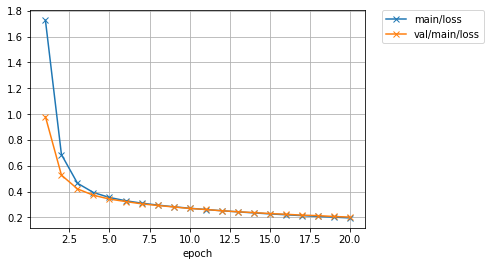

In [16]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

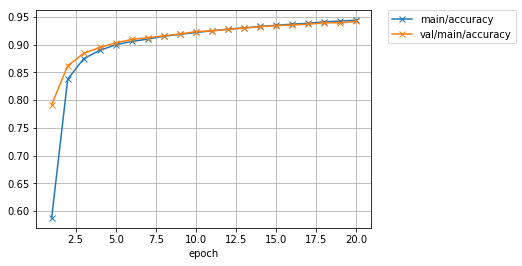

In [18]:
Image(filename='mnist_result/accuracy.png')

In [19]:
%%bash
# ATTENTION: require graphviz
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

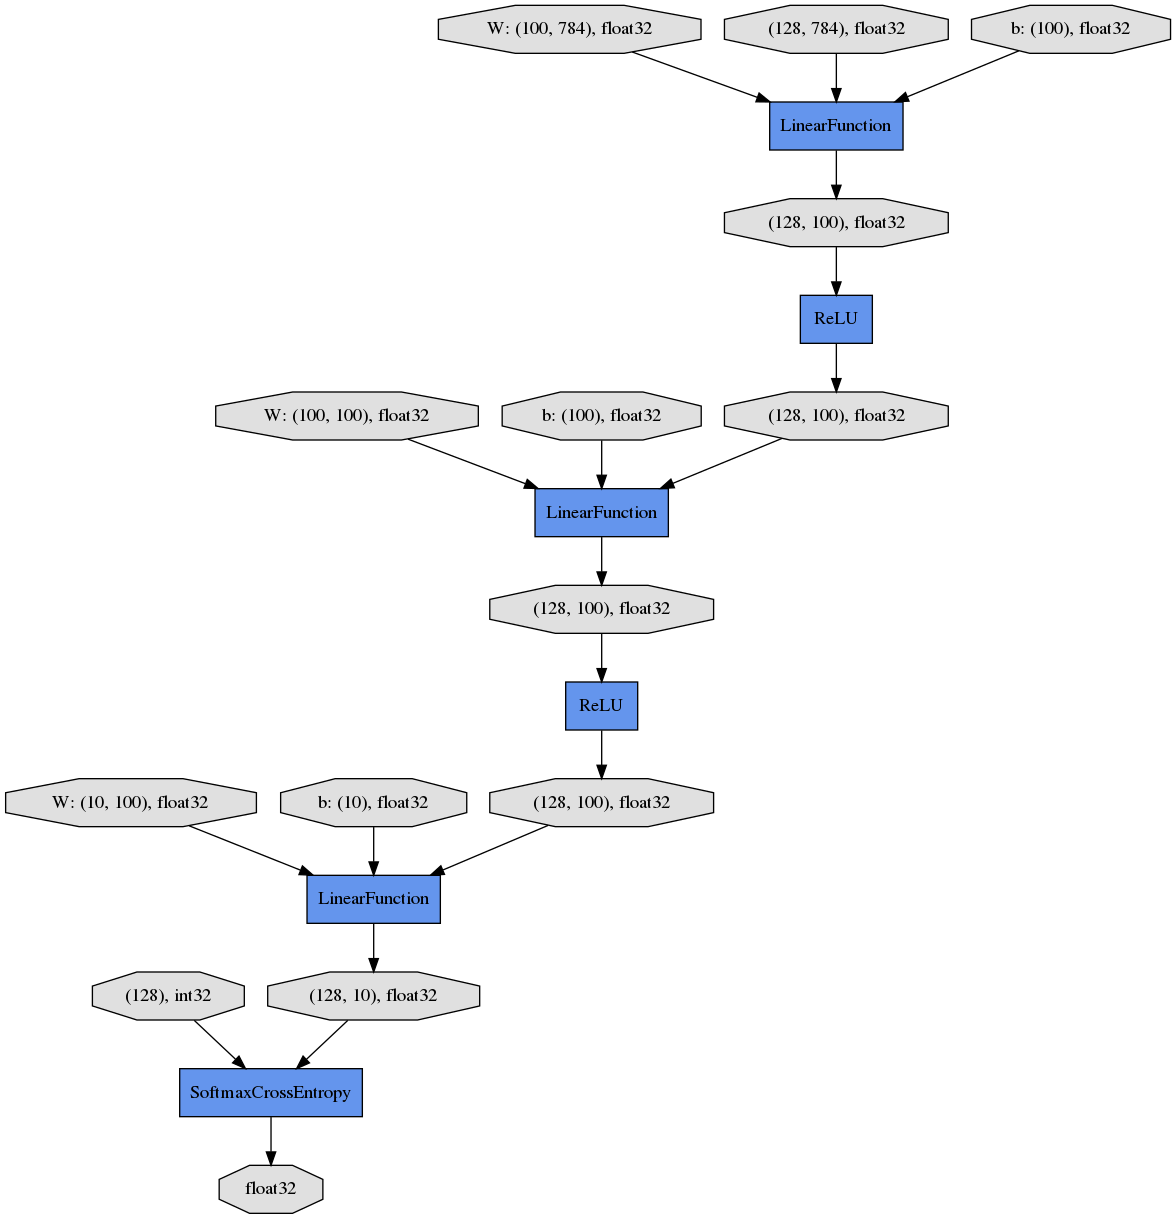

In [20]:
Image(filename='mnist_result/cg.png')

In [21]:
# evaluate accuracy
test_evaluator = extensions.Evaluator(test_iter, model)
results = test_evaluator()
print('Test Accuracy:', round(results['main/accuracy'], 3))

Test Accuracy: 0.944


In [22]:
# save model
from chainer import serializers

serializers.save_npz('mnist_result/my_mnist.model', model)

In [28]:
#load model
infer_net = L.Classifier(Model())
serializers.load_npz('mnist_result/my_mnist.model', infer_net)

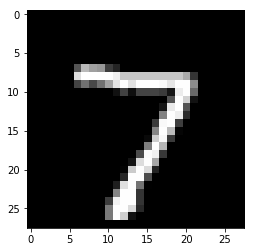

predict result -> 7


In [32]:
# apply infer_net
x, _ = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

x = infer_net.xp.asarray(x[None, ...])

with chainer.using_config('train', False), \
    chainer.using_config('enable_backprop', False):
    #y = infer_net(x)
    y = infer_net.predictor(x).data
    
print('predict result ->', y.argmax(axis=1)[0])